# Australian Weather Forecasting - Imputing Data

## Import libraries

In [25]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools
import matplotlib.pyplot as plt
import scipy.stats as scistat
import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
aussy_Rain = pd.read_csv('../data/weather_imputed.csv')

### Convert our Date column into datetime object

In [3]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Convert Date into Season 
Thanks to https://stackoverflow.com/questions/44124436/python-datetime-to-season 

In [4]:
[(month%12 + 3)//3 for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

Where, in Australia: http://www.bom.gov.au/climate/glossary/seasons.shtml  
* Month 1 = Summer
* Month 2 = Autumn
* Month 3 = Winter
* Month 4 = Spring

In [5]:
aussy_Rain['Date'] = (aussy_Rain.Date.dt.month%12 + 3)//3

In [6]:
aussy_Rain['Date']

0       2
1       1
2       3
3       4
4       1
       ..
2995    1
2996    4
2997    1
2998    1
2999    3
Name: Date, Length: 3000, dtype: int64

### Dummy encoding for other Categoricals

In [7]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
print(encoding)

{'Location': {'PerthAirport': 0, 'Sale': 1, 'Uluru': 2, 'Launceston': 3, 'CoffsHarbour': 4, 'Canberra': 5, 'NorahHead': 6, 'Brisbane': 7, 'Cobar': 8, 'Portland': 9, 'Richmond': 10, 'SalmonGums': 11, 'Townsville': 12, 'AliceSprings': 13, 'Dartmoor': 14, 'Tuggeranong': 15, 'GoldCoast': 16, 'SydneyAirport': 17, 'Watsonia': 18, 'Katherine': 19, 'Mildura': 20, 'Newcastle': 21, 'WaggaWagga': 22, 'Albury': 23, 'Moree': 24, 'Sydney': 25, 'Penrith': 26, 'Bendigo': 27, 'BadgerysCreek': 28, 'MelbourneAirport': 29, 'Perth': 30, 'Woomera': 31, 'NorfolkIsland': 32, 'Darwin': 33, 'Hobart': 34, 'Walpole': 35, 'Wollongong': 36, 'MountGambier': 37, 'Nhil': 38, 'PearceRAAF': 39, 'Ballarat': 40, 'Albany': 41, 'Nuriootpa': 42, 'Witchcliffe': 43, 'MountGinini': 44, 'Adelaide': 45, 'Williamtown': 46, 'Cairns': 47, 'Melbourne': 48}, 'WindGustDir': {'E': 0, 'SSE': 1, 'NNW': 2, 'WSW': 3, 'S': 4, 'SW': 5, 'ENE': 6, 'SE': 7, 'N': 8, 'NE': 9, 'SSW': 10, 'NNE': 11, 'ESE': 12, 'W': 13, 'NW': 14, 'WNW': 15}, 'WindDir

In [8]:
aussy_Rain = aussy_Rain.replace(encoding)

Remove RISK_MM (kaggle dataset authors say this variable should be removed)

In [9]:
aussy_Rain = aussy_Rain.drop(['RISK_MM'], axis=1)

### Visualize model with priors

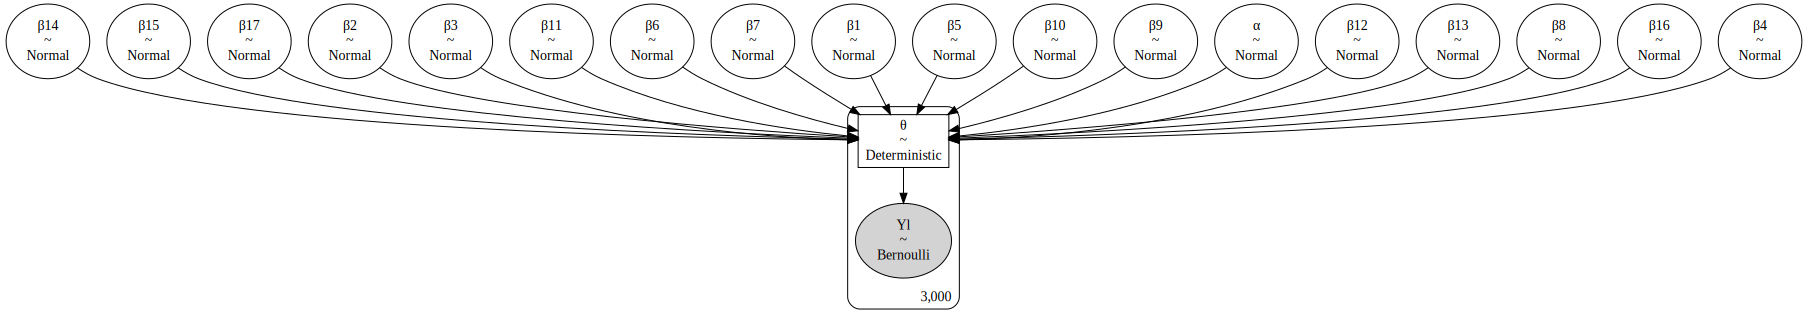

In [10]:
#### Posterior Distribution of parameters# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .

with pm.Model() as manual_logistic_model:
    Y = aussy_Rain["RainTomorrow"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100)
    β10 = pm.Normal('β10', mu=0, sd=100)
    β11 = pm.Normal('β11', mu=0, sd=100)
    β12 = pm.Normal('β12', mu=0, sd=100)
    β13 = pm.Normal('β13', mu=0, sd=100)
    β14 = pm.Normal('β14', mu=0, sd=100)
    β15 = pm.Normal('β15', mu=0, sd=100)
    β16 = pm.Normal('β16', mu=0, sd=100)
    β17 = pm.Normal('β17', mu=0, sd=100)


    μ = α + pm.math.dot(aussy_Rain["MinTemp"], β1) + pm.math.dot(aussy_Rain["MaxTemp"],β2) + pm.math.dot(aussy_Rain["Rainfall"], β3) + pm.math.dot(aussy_Rain["WindGustSpeed"],β4) + pm.math.dot(aussy_Rain["WindSpeed9am"], β5) + pm.math.dot(aussy_Rain["WindSpeed3pm"],β6) + pm.math.dot(aussy_Rain["Humidity9am"], β7) + pm.math.dot(aussy_Rain["Humidity3pm"],β8) + pm.math.dot(aussy_Rain["Pressure9am"], β9) + pm.math.dot(aussy_Rain["Pressure3pm"], β10) + pm.math.dot(aussy_Rain["Pressure9am"], β11) + pm.math.dot(aussy_Rain["Location"], β12) + pm.math.dot(aussy_Rain["WindGustDir"],β13) + pm.math.dot(aussy_Rain["WindDir9am"],β14) + pm.math.dot(aussy_Rain["WindDir3pm"],β15) + pm.math.dot(aussy_Rain["RainToday"],β16) + pm.math.dot(aussy_Rain["Date"], β17) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)
pm.model_to_graphviz(manual_logistic_model)

### MAP ESTIMATE FOR Parameters (Logistic)

In [11]:
map_estimate

{'α': array(-0.11615305),
 'β1': array(0.03467683),
 'β2': array(-0.25259183),
 'β3': array(0.18960019),
 'β4': array(0.17191123),
 'β5': array(0.09716811),
 'β6': array(-0.00064684),
 'β7': array(0.33094086),
 'β8': array(0.5520963),
 'β9': array(-0.02188043),
 'β10': array(-0.02276001),
 'β11': array(-0.02188043),
 'β12': array(-0.00658039),
 'β13': array(0.01798678),
 'β14': array(-0.01931399),
 'β15': array(-0.0853686),
 'β16': array(0.19694559),
 'β17': array(-0.1861839),
 'θ': array([0.1452353 , 0.46834294, 0.26945826, ..., 0.21236595, 0.48754992,
        0.27329075])}

In [12]:
with pm.Model() as logistic_model:
        Y = aussy_Rain.RainTomorrow
        pm.glm.GLM.from_formula('Y ~ MinTemp + MaxTemp + Rainfall + WindGustSpeed + WindSpeed9am + WindSpeed3pm + Humidity9am + Humidity3pm + Pressure9am + Pressure3pm + Temp9am + Temp3pm + Location + WindGustDir + WindDir9am + WindDir3pm + RainToday + Date', aussy_Rain, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000, cores=4, init='adapt_diag', target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Date, RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.


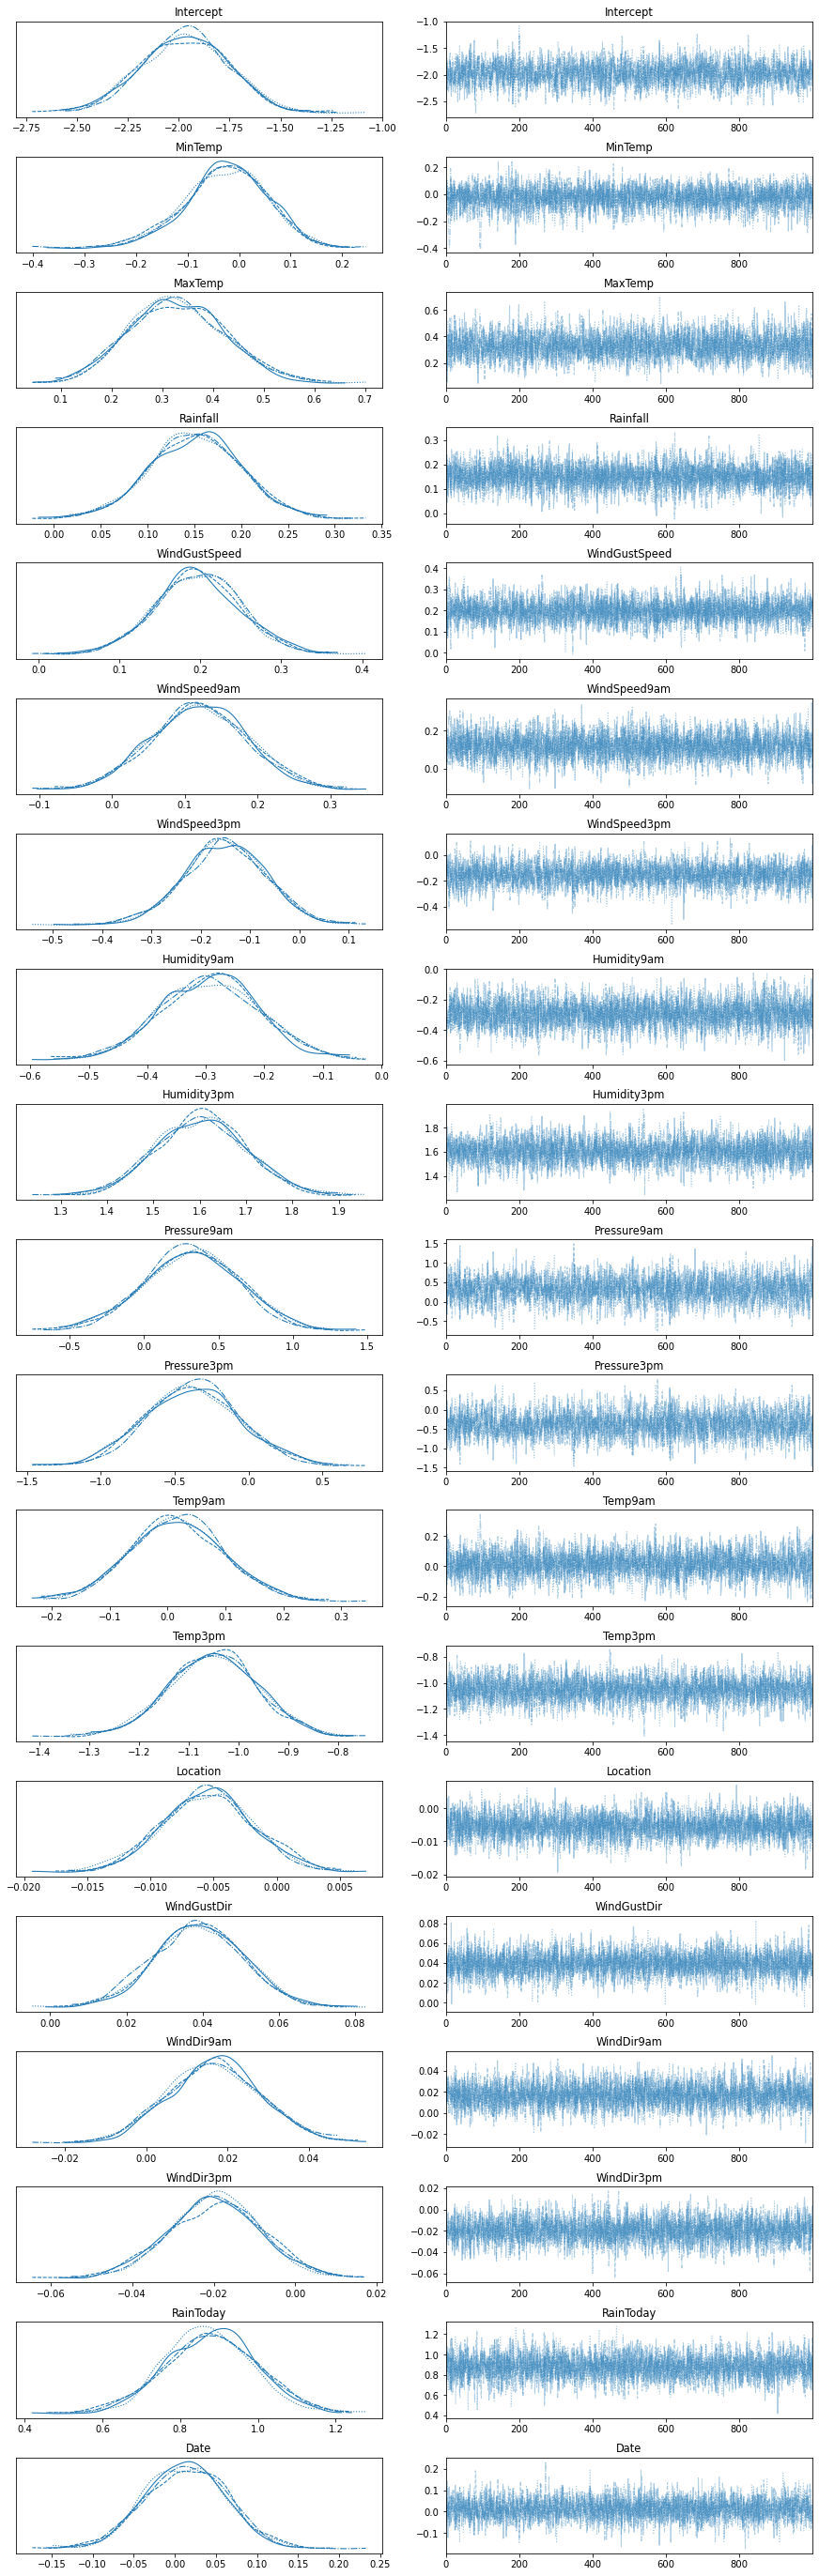

In [13]:
with pm.Model() as logistic_model:
    pm.traceplot(trace)

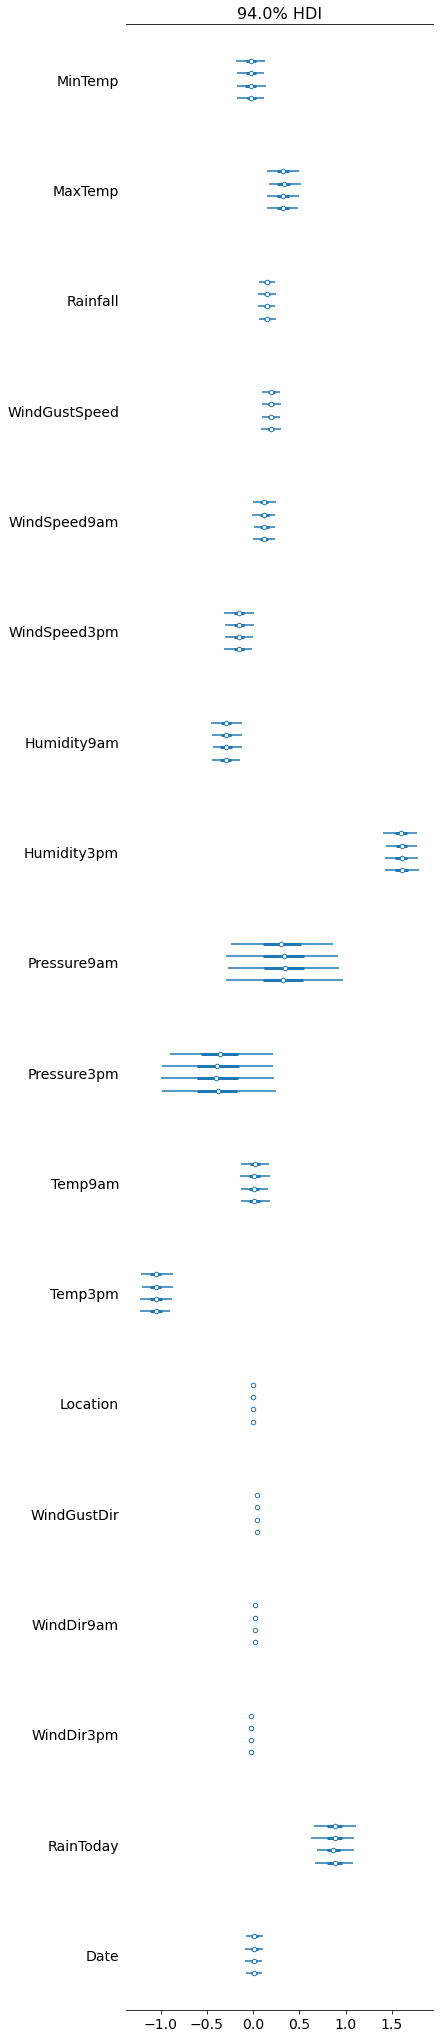

In [14]:
with pm.Model() as logistic_model:
    az.plot_forest(trace, var_names="~Intercept")

### Unpooled Model

In [15]:
Local = aussy_Rain.Location.unique()
locations = len(Local)
Location_lookup = dict(zip(Local, range(len(Local))))
location_Code = aussy_Rain['Location'] = aussy_Rain.Location.replace(Location_lookup).values 
print(aussy_Rain['Location'])

0        0
1        1
2        2
3        3
4        4
        ..
2995     4
2996    17
2997     5
2998    25
2999    20
Name: Location, Length: 3000, dtype: int64


In [16]:
Rainfall = aussy_Rain['Rainfall']
RainTomorrow =aussy_Rain['RainTomorrow']

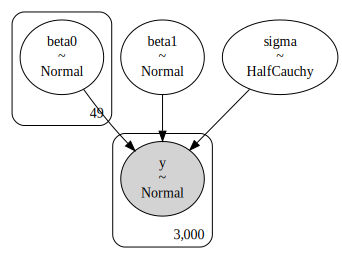

In [144]:
with pm.Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=locations)
    beta1 = pm.Normal('beta1', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta0[location_Code] + beta1*Rainfall
    y = pm.Normal('y', theta, sd=sigma, observed=RainTomorrow)
pm.model_to_graphviz(unpooled_model)

In [18]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.17,0.05,0.07,0.26,0.0,0.0,12036.21,10012.48,11999.21,3038.80,1.00
beta0[1],0.16,0.05,0.06,0.27,0.0,0.0,9046.44,7362.44,9059.19,2609.48,1.00
beta0[2],0.09,0.07,-0.03,0.22,0.0,0.0,12208.49,4057.71,12296.12,2719.42,1.00
beta0[3],0.22,0.05,0.14,0.32,0.0,0.0,12389.04,10528.63,12439.96,3237.20,1.00
beta0[4],0.29,0.05,0.20,0.38,0.0,0.0,10664.43,10083.52,10680.47,3030.65,1.00
beta0[5],0.18,0.05,0.09,0.28,0.0,0.0,8679.11,7298.41,8655.04,2695.64,1.00
beta0[6],0.37,0.06,0.26,0.48,0.0,0.0,13437.13,12181.26,13418.38,2830.38,1.00
beta0[7],0.23,0.05,0.13,0.33,0.0,0.0,9139.74,7665.57,9261.41,2893.73,1.00
beta0[8],0.16,0.05,0.06,0.26,0.0,0.0,6976.39,6038.42,6951.99,2745.96,1.00
beta0[9],0.33,0.05,0.24,0.42,0.0,0.0,10653.92,10157.49,10660.80,2528.97,1.00


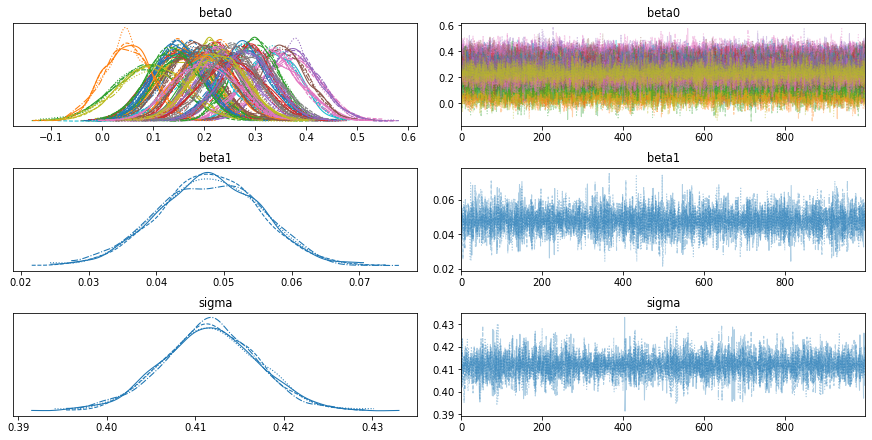

In [19]:
with unpooled_model:
    pm.traceplot(unpooled_trace)

#### Plotting unpooled model

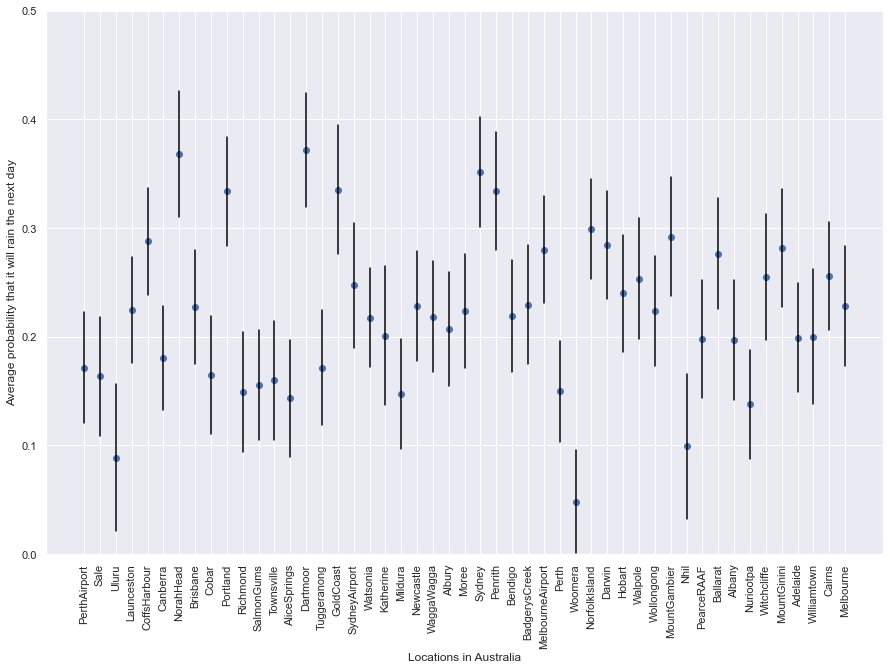

In [138]:
Location_lookup = dict([(value, key) for key, value in encoding['Location'].items()]) 
estimate_unpool = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=Location_lookup.values())
se_unpool = pd.Series(unpooled_trace['beta0'].std(axis=0), index=Location_lookup.values())
import seaborn as sns
plt.figure(figsize = (15,10))
plt.scatter(estimate_unpool.index, estimate_unpool)
for i, m, se in zip(estimate_unpool.index, estimate_unpool, se_unpool):
    plt.plot([i,i], [m-se, m+se], 'black')
plt.xticks(rotation=90)
plt.ylim(0,0.5)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');

### Hierachical Model 

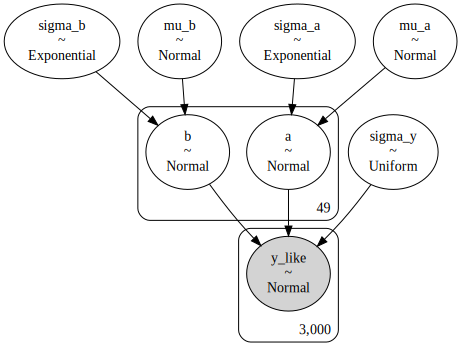

In [22]:
with pm.Model() as intercept_model:
    #Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Exponential("sigma_b", .5)
    #Intercept, Random
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=locations)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=locations)
    #Error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    #E(X)
    y_hat = a[location_Code] + b[location_Code] * Rainfall
    #Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=RainTomorrow)
    
pm.model_to_graphviz(intercept_model)

In [23]:
with intercept_model:
    intercept_model_trace = pm.sample(3500, step = pm.NUTS(target_accept = 0.999), cores = 4, tune=1000)
    intercept_model_idata = az.from_pymc3(intercept_model_trace)
az.summary(intercept_model_idata, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 3_500 draw iterations (4_000 + 14_000 draws total) took 370 seconds.
The acceptance probability does not match the target. It is 0.9938661807524807, but should be close to 0.999. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.24,0.01,0.22,0.26,0.0,0.0,4565.63,4565.63,4566.46,7217.86,1.00
mu_b,0.21,0.04,0.13,0.28,0.0,0.0,4398.37,4398.37,4389.92,7273.76,1.00
a[0],0.23,0.03,0.16,0.29,0.0,0.0,10953.40,10953.40,11325.07,8797.19,1.00
a[1],0.21,0.03,0.15,0.27,0.0,0.0,5540.25,5540.25,5811.30,7456.38,1.00
a[2],0.21,0.04,0.14,0.28,0.0,0.0,5693.04,5693.04,5916.76,7721.33,1.00
...,...,...,...,...,...,...,...,...,...,...,...
b[47],0.12,0.05,0.03,0.20,0.0,0.0,14990.47,13789.97,14981.38,10215.15,1.00
b[48],0.10,0.04,0.02,0.18,0.0,0.0,16765.77,15164.10,16770.81,10927.03,1.00
sigma_a,0.04,0.01,0.01,0.06,0.0,0.0,742.62,742.62,747.54,519.45,1.01
sigma_b,0.19,0.03,0.13,0.26,0.0,0.0,3105.30,3105.30,3013.55,5172.82,1.00


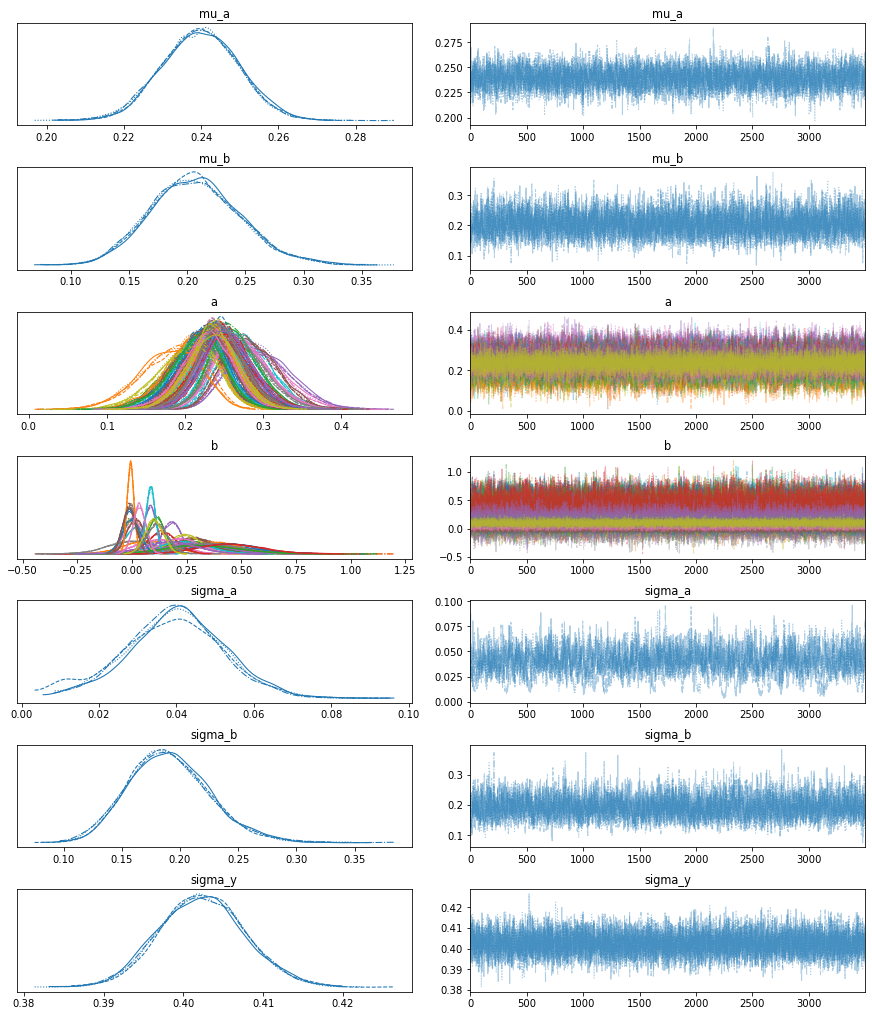

In [24]:
with intercept_model:
    pm.traceplot(intercept_model_trace)

In [32]:
w = az.waic(unpooled_trace)
w

Computed from 4000 by 3000 log-likelihood matrix

          Estimate       SE
elpd_waic -1621.08    37.29
p_waic       53.33        -

There has been a warning during the calculation. Please check the results.

In [40]:
Location_lookup

{0: 'PerthAirport',
 1: 'Sale',
 2: 'Uluru',
 3: 'Launceston',
 4: 'CoffsHarbour',
 5: 'Canberra',
 6: 'NorahHead',
 7: 'Brisbane',
 8: 'Cobar',
 9: 'Portland',
 10: 'Richmond',
 11: 'SalmonGums',
 12: 'Townsville',
 13: 'AliceSprings',
 14: 'Dartmoor',
 15: 'Tuggeranong',
 16: 'GoldCoast',
 17: 'SydneyAirport',
 18: 'Watsonia',
 19: 'Katherine',
 20: 'Mildura',
 21: 'Newcastle',
 22: 'WaggaWagga',
 23: 'Albury',
 24: 'Moree',
 25: 'Sydney',
 26: 'Penrith',
 27: 'Bendigo',
 28: 'BadgerysCreek',
 29: 'MelbourneAirport',
 30: 'Perth',
 31: 'Woomera',
 32: 'NorfolkIsland',
 33: 'Darwin',
 34: 'Hobart',
 35: 'Walpole',
 36: 'Wollongong',
 37: 'MountGambier',
 38: 'Nhil',
 39: 'PearceRAAF',
 40: 'Ballarat',
 41: 'Albany',
 42: 'Nuriootpa',
 43: 'Witchcliffe',
 44: 'MountGinini',
 45: 'Adelaide',
 46: 'Williamtown',
 47: 'Cairns',
 48: 'Melbourne'}

In [41]:
estimate_unpool

0     0.171475
1     0.163507
2     0.088727
3     0.224537
4     0.287849
5     0.180558
6     0.368199
7     0.227748
8     0.164703
9     0.334014
10    0.149035
11    0.155684
12    0.160009
13    0.143248
14    0.371906
15    0.171597
16    0.335134
17    0.247354
18    0.217678
19    0.200925
20    0.147261
21    0.228219
22    0.218599
23    0.207040
24    0.223483
25    0.351690
26    0.334024
27    0.219074
28    0.229376
29    0.280083
30    0.149651
31    0.048447
32    0.299104
33    0.284412
34    0.239805
35    0.253465
36    0.223543
37    0.292084
38    0.099074
39    0.198105
40    0.276508
41    0.197036
42    0.137848
43    0.254608
44    0.281642
45    0.198952
46    0.200005
47    0.256038
48    0.228257
dtype: float64

,index,RainTomorrow
0,PerthAirport,0.171475
1,Sale,0.163507
2,Uluru,0.088727
3,Launceston,0.224537
4,CoffsHarbour,0.287849
5,Canberra,0.180558
6,NorahHead,0.368199
7,Brisbane,0.227748
8,Cobar,0.164703
9,Portland,0.334014
